<a href="https://colab.research.google.com/github/BecomeAllan/ML-SLRC/blob/Allan/Application/Classification_automation_SLR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introdução

Este notebook tem como objetivo dois itens:

+ Realizar buscas científicas da literatura no [Semantic Scholar](https://www.semanticscholar.org/) através do pacote [S2Query](https://github.com/BecomeAllan/S2Query).
+ Utilizar o modelo [ML-SLCR](https://github.com/BecomeAllan/ML-SLRC/blob/main/Meta_learning_EFL.ipynb) para a inclusão/exclusão de artigos na revisão sistemática da literatura.

# Depedências

Algumas dependências a ser instaladas para o funcionamento do notebook

In [1]:
!pip install S2query
!pip install transformers==4.16.2
!pip install torchmetrics==0.8.0
!git lfs install
!git clone https://huggingface.co/becomeallan/ML-SLRC
!pip install crossrefapi

# !pip install matplotlib==3.5.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.5 MB 14.9 MB/s 
     |████████████████████████████████| 6.6 MB 37.0 MB/s 
     |████████████████████████████████| 880 kB 21.3 MB/s 
     |████████████████████████████████| 596 kB 38.2 MB/s 
     |████████████████████████████████| 86 kB 4.4 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=80cf42f88162acb897b94198a5c0107ba160e17016a2a564f500f66393ebd804
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.d

In [2]:
from itertools import chain
import numpy as np
import pandas as pd

import ipywidgets as widgets
from ipywidgets import  Layout
from IPython.display import HTML, display, clear_output, Markdown

%matplotlib inline
import torch.nn.functional as F
import torch.nn as nn
import math
import torch
import time
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.manifold import TSNE
from copy import deepcopy, copy
import seaborn as sns
import matplotlib.pylab as plt
from pprint import pprint
import shutil
import datetime
import re
import json
from pathlib import Path
from crossref.restful import Works


import sys
sys.path.append('/content/ML-SLRC/')

path = '/content/ML-SLRC/'

model_path = path + 'model.pt'
info_path = path + 'Info.json'



from Util_funs import train_loop, prepare_data, SLR_Classifier, Encoder, SLR_DataSet
# Tipo de device para colocar o modelo  (GPU, CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# carrega o modelo
model = torch.load(model_path)

# carrega as meta informações do modelo treinado
with open(info_path, 'r') as f:
  Info = json.load(f)

# Configura algumas meta informações
Info["tokenizer"] = AutoTokenizer.from_pretrained(Info['model'],
                                          do_lower_case = True)
Info['threshold'] = 0.9
Info["inner_update_step_eval"] = 3
Info["inner_print"] = 1

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/223k [00:00<?, ?B/s]

# Search no Semantic scholar

Para realizar a pesquisa da literatura, é possível utilizar duas funções, dentre elas:

+ `SearcherAPI`: Utiliza a API do semantic scholar.
+ `SearcherWeb`: Utiliza a página web do semantic scholar para fazer a raspagem dos dados.

Dentre as funções de busca, é remendável utilizar 'keywords' para o retorno de artigos para a classificação sistemática, no qual deve-se usar aspas simples para cada 'keyword'. Para a inclusão de 'keywords' utiliza-se '+' e exclusão '-'.

Exemplo: `'artificial intelligence' + 'Deep Learning' - 'Biology'`



## Utilizando a API para fazer a busca de dados

Dentre os parâmetros disponíveis, o 'text-box'

In [3]:
#@title SearcherAPI
from S2query import S2paperAPI
from multiprocessing import Pool

# Interface de busca utilizando a API do SS
class SearcherAPI():
  def __init__(self):
    # cria o objeto para puxar os dados
    self.obj = S2paperAPI()

    self.find = False
  
    self.save_b = widgets.Button(description="Export Articles")
    self.save_b.on_click(self.post_processing)
    self.save_all_b = widgets.Button(description="Export All")
    self.save_all_b.on_click(self.save_data)
    
    # Cria os buttoes/textbox
    self.search_b = widgets.Button(description="Search")
    self.search_text =  widgets.Textarea(
        description=":Query",
    value="'artificial intelligence' + 'Deep Learning' - 'Biology'",
    placeholder='Type something',
    layout=Layout(width='50%', height='60px',
                  display= 'flex', flex_flow= 'row-reverse'),
    # description=':',
    disabled=False
) 
    
    self.number_papers = widgets.IntText(
    value=100,
    min=2,
    # layout = widgets.Layout(width='180px'),
    style= {'description_width': 'initial'},
    layout=Layout(width='180px',
                  display= 'flex', flex_flow= 'row-reverse'),
    description=' Number of papers',
    disabled=False)

    # self.leftbox = widgets.HBox([self.search_text])
    self.rightbox = widgets.VBox([self.search_text, self.number_papers, self.search_b])
    
    # self.hbox = widgets.HBox([self.leftbox, self.rightbox])
    self.save_h = widgets.HBox([self.save_b, self.save_all_b])
    
    # Funcao quando clicar o botao
    self.search_b.on_click(self.search_button)


  # Search button
  def search_button(self, p):
    print(self.search_text.value)
    # Busca os dados
    self.obj.get(self.search_text.value,
                 n=self.number_papers.value,
                 fields = ['externalIds', 'paperId', 'url', 'title', \
                           'abstract', 'venue', 'year', 'referenceCount', \
                           'citationCount', 'influentialCitationCount', \
                           'isOpenAccess', 'fieldsOfStudy', 'authors'])


    # Guarda os dados achados
    self.data = self.obj.all

    # self.data

    self.find = True
    self.__call__()


  def post_processing(self, p):
    self.data = self.data.rename(columns = {'externalIds':'doi'})
    doi = [d.get('DOI') for d in self.data.doi]
    self.data['doi'] = doi
    null = self.data.doi.isnull().values
    self.data = self.data.drop(self.data[null].index)
    self.data = self.data[self.data.doi != '']


    self.works = Works()
    tipos_docs = []

    dois = self.data.doi.to_list()

    # with Pool(2) as p:
    #   tipos_docs = p.map(self.multiprocessing, dois)

    print("processing ...")

    for doi in dois:
      try: 
        t = self.works.doi(doi)['type']
      except:
        t = ''
      tipos_docs.append(t)

    self.data['type'] = tipos_docs
    mask = ['journal-article', 'proceedings-article']
    self.data_a = self.data[self.data['type'].isin(mask)]
    self.data_a=self.data_a.reset_index().drop('index', axis = 1)
    self.data_a.to_csv("data_API_Articles.csv")

    self.__call__()
    print("Saved as data_API_Articles.csv")




  def save_data(self, p):
    self.data.to_csv("data_API.csv")
    self.__call__()
    print("Saved as data_API.csv")

  

  def multiprocessing(self, data):
    try: 
      t = self.works.doi(data)['type']
    except:
      t = ''
    
    return t



  # Funcao para chamar a classe
  def __call__(self):
    clear_output()
    # Mostra os butoes
    display(self.rightbox)
    if self.find:
      display(self.save_h)

In [4]:
resultAPI = SearcherAPI()
resultAPI()

Saved as data_API_Articles.csv


## Utilizando a Web para fazer a busca de dados

In [5]:
#@title SearcherWeb
from S2query import S2paperWeb

# Interface de busca utilizando a Web do SS
class SearcherWeb():
  def __init__(self):
    # cria o objeto para puxar os dados
    self.obj = S2paperWeb()
    self.find = False


    # Cria os buttoes/textbox
    self.search_b = widgets.Button(description="Search")
    self.search_text =  widgets.Textarea(
    value="'artificial intelligence' + 'Deep Learning' - 'Biology'",
    placeholder='Type something',
    layout=Layout(width='50%', height='60px',
                  display= 'flex', flex_flow= 'row-reverse'),
    # description=':',
    disabled=False
)
        # Funcao quando clicar o botao
    self.search_b.on_click(self.search_button)


    self.save_all_b = widgets.Button(description="Export Data")
    self.save_all_b.on_click(self.save_data)

    # Configura opcoes possiveis do parametro sort
    self.sort = widgets.Dropdown(
    options = ["total-citations", "influence", "pub-date", "relevance"],
    value = 'relevance',
    description = 'Sort by',
    layout=Layout(width='180px',
                  display= 'flex', flex_flow= 'row-reverse'),
    disabled = False
)
    
    # Configura opcoes possiveis do parametro venue
    self.venue = widgets.SelectMultiple(
    options=["PloS one", "AAAI", "Scientific reports", "IEEE Access", \
             "ArXiv", "Expert Syst. Appl.""ICML", "Neurocomputing", \
             "Sensors", "Remote. Sens."],
    value=[],
    layout=Layout(width='300px'),
    #rows=10,
    description='venue',
    disabled=False
)

    # Criando um botao de selecionar todos
    # para as venues
    self.but_venue = widgets.Button(description = 'All venues')

    self.but_venue.on_click(self.venue_button)

    # Configura as opcoes do parametro yearFilter
    self.min = widgets.IntText(
    description='Min. year: ',
    value=2000,
    disabled=False
)

    self.max = widgets.IntText(
    description='Max. year: ',
    value=2022,
    disabled=False
)
    


    # Configura as opcoes do parametro publicationTypes
    self.pubtype = widgets.SelectMultiple(
    options=["ClinicalTrial","CaseReport","Editorial","Study", "Book",\
             "News","Review","Conference","LettersAndComments",\
             "JournalArticle"],
    value=[],
    #rows=10,
    description='Publication',
    disabled=False
)
    
    # Criando um botao de selecionar todos
    # para as venues
    self.but_pub = widgets.Button(description = 'All pub. types')

    self.but_pub.on_click(self.pub_button)

    # Configura as opcoes do parametro fieldsOfStudy
    self.fos = widgets.SelectMultiple(
    options=["agricultural-and-food-sciences","art","biology",\
             "business","computer-science","chemistry","economics",\
             "education","engineering","environmental-science",\
             "geography","geology","history","law","linguistics",\
             "materials-science","mathematics","medicine","philosophy",\
             "physics","political-science","sociology","psychology"],
    value=[],
    #rows=10,
    description='fieldsOfStudy',
    disabled=False
)

    # Criando um botao de selecionar todos
    # para as venues
    self.but_fos = widgets.Button(description = 'All fields')

    self.but_fos.on_click(self.fos_button)

    self.number_papers = widgets.IntText(
    value=100,
    min=2,
    # layout = widgets.Layout(width='180px'),
    style= {'description_width': 'initial'},
    layout=Layout(width='180px',
                  display= 'flex', flex_flow= 'row-reverse'),
    description=' Number of papers',
    disabled=False)

    # self.leftbox = widgets.HBox([self.search_text])
    self.vbox1 = widgets.VBox([self.sort, self.number_papers])
    self.hbox1 = widgets.HBox([self.search_text, self.vbox1])
    self.hbox2 = widgets.HBox([self.min, self.max])
    self.hbox3 = widgets.HBox([self.venue, self.but_venue])
    self.hbox4 = widgets.HBox([self.pubtype, self.but_pub])
    self.hbox5 = widgets.HBox([self.fos, self.but_fos])
    
    self.Vbox = widgets.VBox([self.hbox1,
                              self.hbox2,
                              self.hbox3,
                              self.hbox4,
                              self.hbox5,
                              self.search_b
                              ])
    

  # Search button
  def search_button(self, p):
    # self.__call__()
    
    print(self.search_text.value)
    # Busca os dados


    self.yearfilter = {"min": self.min.value, "max": self.max.value}
    self.obj.get(self.search_text.value,
                 n=self.number_papers.value,
                 sort = self.sort.value,
                 venue = self.venue.value,
                 yearFilter = self.yearfilter,
                 publicationTypes = self.pubtype.value,
                 fieldsOfStudy = self.fos.value)


    # Guarda os dados achados
    self.data = self.prepare_data(self.obj.all)
    self.find = True
    self.__call__()

    # print("done")
  
  # Definindo a funcao do botao de field of study
  def fos_button(self, p):

    self.fos.value = self.fos.options

  # Definindo a funcao do botao de venue
  def venue_button(self, p):

    self.venue.value = self.venue.options

  # Definindo a funcao do botao de pubtype
  def pub_button(self, p):

    self.pubtype.value = self.pubtype.options


  # cria um subset dictionary da funcao que busca os dados
  def subset(self, dicttosub):
    # Seleciona apenas as colunas
    subdict = {k:dicttosub[k] for k in ('title','paperAbstract',
                                        'year', 'primaryPaperLink',
                                        'entities', 'fieldsOfStudy',
                                        'citationStats')}

    # Renomeia a key do dictionar
    subdict['abstract'] = subdict.pop('paperAbstract')
    subdict['numReferences'] = subdict['citationStats']['numReferences']
    subdict['numCitations'] = subdict['citationStats']['numCitations']
    subdict.pop('citationStats')
    
    # Guarda apenas um link de referencia
    try:
      subdict['link'] = subdict['primaryPaperLink']['url']
    except:
      subdict['link'] = np.nan

    subdict.pop('primaryPaperLink')

    return subdict

  
  def save_data(self, p):
    self.data.to_csv("data_WEB.csv")
    self.__call__()
    print("Saved as data_WEB.csv")


  # Trata os dados para transformar de json para pandas.dataframe
  def prepare_data(self, data):

    # Loop sobre os resultados para selecionar tudo em uma lista
    papers = []
    for x in data['Results']:
      papers_page = [self.subset(paper) for paper in x['Page']['Papers']]
      papers.append(papers_page)
    papers = list(chain.from_iterable(papers))

    # Transforma em Pandas
    data = pd.DataFrame(papers)
    return data
  
  # Funcao para chamar a classe
  def __call__(self):
    clear_output()
    # Mostra os butoes
    display(self.Vbox)
    if self.find:
      display(self.save_all_b)

In [6]:
resultWEB = SearcherWeb()
resultWEB()

Button(description='Export Data', style=ButtonStyle())

Saved as data_WEB.csv


In [7]:
resultWEB.data.head(2)

title  year entities  \
0  Artificial intelligence: Deep learning in onco...  2021       []   
1  Unraveling the deep learning gearbox in optica...  2021       []   

        fieldsOfStudy                                           abstract  \
0  [Computer Science]                                                      
1  [Computer Science]  Machine learning has greatly facilitated the a...   

   numReferences  numCitations                                          link  
0            118            19  https://www.ncbi.nlm.nih.gov/pubmed/33765601  
1            120             4    https://doi.org/10.1038/s42003-021-01697-y

# Treinando o modelo para rotular os dados nao rotulados

In [8]:
#@title Funções para classificar dados e treinar o modelo

from scipy import stats
import matplotlib.patches as mpatches

from ipywidgets import GridspecLayout
from scipy.stats import poisson


class Judger():
  def __init__(self, data, configure_text= True):
    self.data = data
    self.selected_indx = []
    self.index = 0
    
    # Distribuicao para fazer amostragem para rotulagem
    density = poisson.pmf(range(len(self.data)), mu=10)

    # indexs aleatorios
    self.shuffle = np.random.choice(
                     range(len(data)),
                     p=density,
                     replace=False,
                     size=len(data))
    
    if configure_text:
      # cria uma coluca no data como text (title + abstract) para ser classificado pelo oraculo
      self.data.fillna(value='', inplace=True)
      self.data['text'] = self.data['title']  +'. ' + self.data['abstract']
      self.data['label'] = np.nan

    # Botoes
    self.next_b = widgets.Button(description="Next")
    self.previous_b = widgets.Button(description="Previous")

    self.Included = widgets.Button(description="Included")
    self.NIncluded = widgets.Button(description="Not Included")
    self.erase_b = widgets.Button(description="Erase")

    # Funcao quando clicar nos botoes
    self.next_b.on_click(self.next_button)
    self.previous_b.on_click(self.prev_button)
    
    self.Included.on_click(self.Included_button)
    self.NIncluded.on_click(self.Not_Included_button)
    self.erase_b.on_click(self.erase_button)

    # Configuracao da localizacao dos botoes
    self.Judger_hbox1 = widgets.HBox([self.NIncluded, self.Included])
    self.Judger_hbox2 = widgets.HBox([self.previous_b, self.next_b, self.erase_b])
    self.Judger_grid = widgets.VBox([self.Judger_hbox1,self.Judger_hbox2]) 

  # Incluir na revisao button
  def Included_button(self, p):
    self.data.loc[self.shuffle[self.index], 'label'] = 'Included'
    self.index += 1
    self.__call__()

  # Excluir da revisao button
  def Not_Included_button(self, p):
    self.data.loc[self.shuffle[self.index], 'label'] = 'Not Included'
    self.index += 1
    self.__call__()


  # Apagar rotulagem
  def erase_button(self, p):
    text = self.data.loc[self.shuffle[self.index], 'text']
    self.data.loc[self.shuffle[self.index], 'label'] = np.nan

    self.__call__()
    
  # Next button
  def next_button(self, p):
    # Testa se é possivel ir pro proximo texto
    try:
      self.index +=1
      text = self.data.loc[self.shuffle[self.index], 'text']
    except:
      self.index =0
    self.__call__()

  # Prev button
  def prev_button(self, p):
    # Testa se é possivel ir pro texto anterior
    if self.index-1 <0:
      self.index = len(self.data) - 1
    else:
      self.index -= 1
    
    self.__call__()

  
  # Funcao para chamar o julgador
  def __call__(self):
    clear_output()
    # Quais dados sao nao  rotulados
    criteria_na = self.data['label'].isna()

    # Se acabar de rotular todos os dados
    if sum(criteria_na) == 0 or self.index > len(self.data):
      return print('Finished')

    # Index aleatorio para selecionar um texto para classificacao
    indexs_unlabeled = self.data.loc[criteria_na].index

    # Guarda qual index foi separado pra classificar
    self.selected_indx.append(self.index)

    # Texto e Label do index
    text = self.data.loc[self.shuffle[self.index], 'text']
    label = self.data.loc[self.shuffle[self.index], 'label']
    
    
    statistics = self.data['label'].value_counts()

    try:
      neg = statistics['Not Included']
    except:
      neg = 0
    try:
      pos = statistics['Included']
    except:
      pos = 0

    self.pos = pos
    self.neg = neg
    
    # Print de alguns resultados
    print(f"Current example: {self.index+1} / {len(self.data)}")
    print(f"Unlabeled: {sum(criteria_na)}")
    print(f"Not included examples: {neg} | Included examples: {pos}")
  
    display(self.Judger_grid)
    print('Text:')
    display(Markdown(text))
    print('Label:', label)

class Train():
  def __init__(self, model, data, device, Info):
    self.data = data
    self.model = model
    self.Info= Info
    self.device = device
    self.trained = False
    self.index = 0

    # Cria butoes
    self.train_b = widgets.Button(description="Train")
    self.number_class = widgets.IntText(
    value=2,
    min=2,
    layout = widgets.Layout(width='150px'),
    style= {'description_width': 'initial'},
    description='Size per class:',
    disabled=False)
    self.value_trash = widgets.FloatText(
        min=0,
        max=1,
        step=0.1,
        value=0.5,
        description='Confidence Level:',
        layout = widgets.Layout(width='170px'),
        style= {'description_width': 'initial'},
        disabled=False)

    
    # Configura a localizacao dos botoes
    self.Train_hbox = widgets.HBox([self.train_b, self.number_class, self.value_trash])
    
    # Funcao quando clicar o botao
    self.train_b.on_click(self.train_button)

    self.treshold = self.value_trash.value


  # Train button
  def train_button(self, p):
    clear_output()
    print('Training...')
    # Pre-processa os textos dos dados para passar no modelo
    test_batch_size = 100 if len(self.data)>100 else len(self.data)

    try:
      self.data_train_loader, self.data_test_loader, self.data_train, self.data_test = prepare_data(self.data,
                train_size_per_class = self.number_class.value,
                batch_size = {'train': self.Info['inner_batch_size'],
                              'test': test_batch_size},
                max_seq_length = self.Info['max_seq_length'],
                tokenizer = self.Info['tokenizer'],
                input = "text",
                output = "label")
      
    except:
      self.__call__()
      print('Try another size per class')
      return



    # Treina o modelo e pega o vetor da camada classifier
    self.logits = train_loop(self.data_train_loader, self.data_test_loader,
                                                        self.model, self.device,
                                                        epoch = self.Info['inner_update_step'],
                                                        lr=self.Info['inner_update_lr'],
                                                        print_info=True,
                                                        name = 'test')


    # Sigmoid para deixar entre 0 e 1 a confiança das predições
    predictions = torch.sigmoid(self.logits) 

    # Guarda as predições nos dados de teste
    self.data_test['prediction'] = predictions
    self.data = self.data_test

    self.trained = True
    self.__call__()
    print('Done')

  
  def __call__(self):
    display(self.Train_hbox)


class Interface(Judger, Train):
  def __init__(self, data):
    Judger.__init__(self, data)
    Train.__init__(self, model, self.data, device, Info)

    # Botoes
    self.avaliation_b = widgets.Button(description="Avaliation")
    self.export_b = widgets.Button(description="Export data")
    self.reord_b = widgets.Button(description="Reorder data")

    # Funcao quando clicar nos botoes
    self.avaliation_b.on_click(self.avaliation_button)
    self.export_b.on_click(self.export_button)
    self.reord_b.on_click(self.model_order_button)

    # Disposicao da localizacao dos botoes
    self.avaliate = widgets.HBox([self.export_b, self.avaliation_b, self.reord_b])

  # Reoderna os dados
  def model_order_button(self, p):
    kernel = stats.gaussian_kde(self.data['prediction'])
    prob = (1/kernel(self.data['prediction']))
    prob = prob/sum(prob)
    self.shuffle = np.random.choice(range(len(self.data)),
                                    size=len(self.data),
                                    replace=False,
                                    p = prob)
    self.__call__()

  # Avalia a distribuicao dos dados
  def avaliation_button(self, p):

    self.treshold = self.value_trash.value

    _, _, bars = plt.hist(self.data['prediction'], color="C0")

    for bar in bars:
        if bar.get_x() > self.treshold:
            bar.set_facecolor("C1")
    plt.title("Number of papers by Confidence level")
    plt.xlabel("Confidence level")
    plt.ylabel("Number of papers")

    n_incl = sum(self.data['prediction'] >= self.treshold)
    n_notincl = sum(self.data['prediction'] < self.treshold)

    Inc = mpatches.Patch(color='C1', label=f'(Model) Included: {n_incl}')
    notInc = mpatches.Patch(color='C0', label=f'(Model) Not Included: {n_notincl}')

    plt.legend(handles=[Inc, notInc])
    plt.axvline(self.treshold, color='red', linestyle='dashed', linewidth=1)
    self.__call__()

    plt.show()

  # Salva os dados
  def export_button(self, p):
    data = self.data
    data['model_label'] = (data['prediction'] > self.treshold)*1
    data=data.rename(columns={'prediction': 'confidence'})
    data.to_csv('data.csv')

    self.__call__()
    print('Saved as data.csv')

  # Chama a funcao interface
  def __call__(self):
    Judger.__call__(self)
    
    if (self.pos >= 2 ) & (self.neg >= 2):
      if self.trained:
        prediction = self.data.loc[self.shuffle[self.index], 'prediction']
        # Mostra alguns resultados
        print('Confidence:', prediction)
        print('(Model) Included:', self.treshold <= prediction)
        display(self.avaliate)

      Train.__call__(self)

Para utilizar o modelo, é necessário fazer uma primeira rodada de rotulagem, assim temos os botões:

+ `Not Included`: Rotula o exemplo como não incluido.
+ `Included`: Rotula o exemplo como incluido.
+ `Previous`: Volta ao exemplo anterior.
+ `Next`: Avança para o próximo exemplo.

Esta rotulagem é chamada `Label` e é baseada no `Text` que é a concatenação do "Title" e "Abstract". Para utilizar o objeto `Interface()`, basta instanciar o objeto passando os dados em formato `pandas.DataFrame`, no qual deve-se conter as colunas `title` e `abstract` para o funcionamento deste.

Depois que possuir **2 exemplos incluidos** e **2 não incluido**, o botão `Train` vai aparecer, no qual é possível configurar:

+ `Size per class`: Quantidade de exemplos por rotulos
+ `Confidence Level`: Confiança mínima com que o model possa predizer como Incluido. Este varia entre 0 e 1. 

Ao apertar o botão `Train`, o modelo será treinado e utilizado para rotulagem dos exemplos, no qual a Interface obterá algumas descrições com base no modelo, dentre elas:

+ `Confidence`: Confiança que o modelo fez a predição do exemplo, no qual, quanto mais próximo de 0 ou 1, melhor a predição de não incluido ou incluido respectivamente.
+ `(Model) Included`: Rotulagem feita pelo modelo para a inclusão do exemplo com base no `Confidence Level`.

Depois de treinar o modelo, alguns botões úteis para a avaliação das predições aparecerá:

+ `Export data`: Exportar os dados com bases nos dados de input do `Interface(data)` com novas colunas como `confidence`, `label` e `mode_label`, no qual os **labels 1 e 0** indentifica a inclusão\exclusão respectivamente. 
+ `Avaliation`: Cria um gráfico (histograma) de contágem de exemplos por intervalos de confiança do modelo (`Confidence`), com uma linha vertical mostrando `Confidence Level`. É esperado distribuições perto do 0 e 1, com o número de exemplos 1 menor que 0.
+ `Reorder data`: Faz uma reamostragem e dos dados com base no `confidence` e retorna uma nova ordem de exemplos para avaliar os `text` individualmente.

Depois de treinar o modelo, é possível fazer novas rotulagens corrigindo/confirmando a predição do modelo para uma nova rodada de treino e melhor predição destes, é aconselhado utilizar 8 ou mais exemplos por rotulagem para melhor desempenho do modelo.

Current example: 5 / 100
Unlabeled: 96
Not included examples: 2 | Included examples: 2


Text:


Deep learning for biology. A popular artificial-intelligence method provides a powerful tool for surveying and classifying biological data. But for the uninitiated, the technology poses significant difficulties. A popular artificial-intelligence method provides a powerful tool for surveying and classifying biological data. But for the uninitiated, the technology poses significant difficulties.

Label: nan
Confidence: 0.7315929
(Model) Included: True


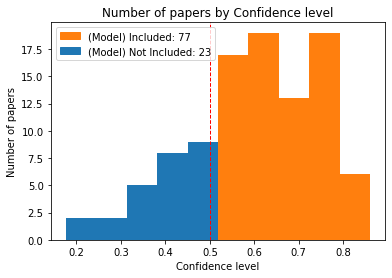

In [9]:
interface = Interface(resultWEB.data)
interface()

Current example: 5 / 35
Unlabeled: 31
Not included examples: 2 | Included examples: 2


Text:


Deep learning-enhanced light-field imaging with continuous validation. 

Label: nan
Confidence: 0.76386094
(Model) Included: True


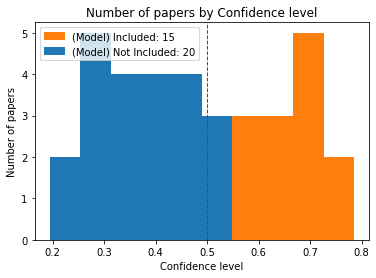

In [10]:
interface = Interface(resultAPI.data_a)
interface()